# TalkingData AdTracking Fraud Detection Challenge

Can you detect fraudulent click traffic for mobile app ads?

## Prerequisites
Please make sure the following Python distributions and packages were installed.

* [Anaconda](https://anaconda.org)
* [XGBoost](https://github.com/dmlc/xgboost)
* [LightGBM](https://github.com/Microsoft/LightGBM) - not needed by week 1
* [Keras](https://keras.io) - not needed by week 1
* [Tensorflow](https://www.tensorflow.org) - not needed by week 1
* [Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) - not needed by week 1
* [seaborn](https://seaborn.pydata.org)
* [bokeh](http://bokeh.pydata.org)

You'll also need to create the following sub-folders in your working folder:

* input
   
   To store all the data files downloaded from Kaggle
   
   
* output
    
    To store submission files
   
   
* python
    
    To store python scripts and ipython notebooks including this one. Make sure you copied each week's notebook into this folder.
    
Please note that Kaggle recently released its official API which can be found from https://github.com/Kaggle/kaggle-api

With the API you can programmably download files, make submissions and browse yor scores.

In [2]:
import numpy as np
from scipy import sparse
import pandas as pd
import xgboost as xgb
import re
import string
import time
import seaborn as sns
import itertools
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import seaborn as sns
import matplotlib.pyplot as plt

import random
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier
import gc


%matplotlib inline 

C:\Users\Tong\Anaconda2\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data initialization

The first major challenge of this competition is the size of data. With a typical configuration of 16GB RAM it's unlikely that we would be able to performan any serious data manipulations or feature engineerings. Fortunately, there are a few schemes that can help ease the pain. Thanks to Kaggler [yulia](https://www.kaggle.com/yuliagm) who kindly shared a great notebook [How to Work with BIG Datasets on 16G RAM (+Dask)
](https://www.kaggle.com/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask) that explains usefull tips in details.

TIP 1 - Deleting unused variables and gc.collect()
TIP 2 - Presetting the datatypes
TIP 3 - Importing selected rows of the a file (including generating your own subsamples)
TIP 4 - Importing in batches and processing each individually
TIP 5 - Importing just selected columns
TIP 6 - Creative data processing
TIP 7 - Using Dask

We don't necessarily need to use all of them except TIP 1, 2 and 5. It's up to you to decide if you'd like to use the rest.

In [10]:
%%time

# Construct a list of rows we want to skip randomly

#skiplines = np.random.choice(np.arange(1, 184903890), 
                             #size=184903890-1-5000000, replace=False)

# Predefine data types for each dolumn
column_types = {'click_id': 'uint32',
                 'app': 'uint16',
                 'channel': 'uint16',
                 'device': 'uint16',
                 'ip': 'uint32',
                 'is_attributed': 'uint8',
                 'os': 'uint16'}

train_data = pd.read_csv('../input/train.csv/train.csv'
                         , dtype=column_types
                         , usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
                         # We also want to process datatime columns seperately
                         , skiprows=range(1,184903890-5000000)
                         , nrows=5000000
                         , parse_dates = ['click_time']
                         , infer_datetime_format=True )

test_data = pd.read_csv('../input/test.csv/test.csv'
                        , dtype=column_types
                        , usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id']
                        , parse_dates = ['click_time']
                        , infer_datetime_format=True )
train_size = train_data.shape[0]

print ('train size: ', train_data.shape, 'test size: ', test_data.shape)

train size:  (5000000, 7) test size:  (18790469, 7)
Wall time: 4min 17s


The codes above load 40M samples randomly from the training data. However, noticed that the training data was somehow sorted by click time wouldn't it make more sense to load samples from the tail of the file? You substitute the file load statement with following:

```python
train_data = pd.read_csv('../input/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv'
                         , dtype=column_types
                         , usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
                         # We also want to process datatime columns seperately
                         , skiprows=range(1,184903890-40000000), 
                         , nrows=40000000
                         , parse_dates = ['click_time']
                         , infer_datetime_format=True )

```

If you are interested in automating the process to construct the data types dictionary below is an example for your reference.


```python
for dtype in ['float','int','category']:
    selected_dtype = test_data.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))
    
```    

## Merge training and testing data
This is a trick I used extensively for Kaggle. The idea is to combine train and test dataset so we don't have to perform the same transformations on both datasets.

In [11]:
full_data=pd.concat([train_data,test_data])

In [12]:
del train_data, test_data
full_data['click_id'] = full_data['click_id'].fillna(0).astype('uint32')
full_data['is_attributed'] = full_data['is_attributed'].fillna(0).astype('uint8')
gc.collect()

65

## Group variables

In [13]:
cat_vars = []

num_vars = ['ip','app','device','os', 'channel']

id_var = 'click_id'
target_var = 'is_attributed'

# Feature engineering

## Missing value imputation

Missing values are not observed in this competition so we don't need to do anything about it. However, XGBoost and LightGBM have a unique way of dealing with missing values which tend to be effective most of the time. By default, the assume Nan as missing value and would try to create splitting point for those samples with Nan. I would be interesting to try the followings and see which works better:


## Pre-processing

### Categorical features - label encoding

Label encoding is not really necessary for this competition as all categorical features have already been digitalized. I'm simply including this just for your reference.

```python
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].fillna(-1))
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (LE_vars))
```


### Categorical features - one hot encoding¶

Performing One-hot encoding for this competition is unlikely going to work due to the size of data. However, if we want to use other algorithms such as MLP we'll still have to do it. 

Another tip for OHE is that you don't want to concatenate the converted OHE features with the original dataframe(full_data) becuase it would exponentially enlarge the size of the dataframe. In fact, it's recommended to use scipy.sparse.hstack to concatenate the data which you will see in the following sections.


```python
OHE = preprocessing.OneHotEncoder(sparse=True)
start=time.time()
OHE.fit(full_data[LE_vars])
OHE_sparse=OHE.transform(full_data[LE_vars])
                                   
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))


OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in cat_vars for level in LE_map[var] ]

print ("OHE_sparse size :" ,OHE_sparse.shape)
print ("One-hot encoded catgorical feature samples : %s" % (OHE_vars[:100]))

```

## Numeric features

For the first two two weeks we will be using XGBoost/LightGBM which typically don't require pre-processing for numeric features so we will skip this part until week 3.

## Datetime features

Exact datetime elements, e.g hour, day and day of week. Feel free to try extracting others such as minute, day of year and so on.

In [14]:
full_data['hour'] = pd.to_datetime(full_data.click_time).dt.hour.astype('uint8')
full_data['day'] = pd.to_datetime(full_data.click_time).dt.day.astype('uint8')
full_data['dow']  = pd.to_datetime(full_data.click_time).dt.dayofweek.astype('uint8')

dt_vars = ['hour','day', 'dow']
gc.collect()

21

In [15]:
tmp = full_data[['ip','day','hour','channel']].groupby(by=['ip','day','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'qty'})
tmp['qty'] = tmp['qty'].astype('uint16')
full_data = full_data.merge(tmp, on=['ip','day','hour'], how='left')
del tmp
gc.collect()


tmp = full_data[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
tmp['ip_app_count'] = tmp['ip_app_count'].astype('uint16')
full_data = full_data.merge(tmp, on=['ip','app'], how='left')
del tmp
gc.collect()

tmp = full_data[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
tmp['ip_app_os_count'] = tmp['ip_app_os_count'].astype('uint16')
full_data = full_data.merge(tmp, on=['ip','app', 'os'], how='left')
del tmp
gc.collect()

interact_vars = ['qty', 'ip_app_count', 'ip_app_os_count']

In [16]:
full_vars = num_vars + dt_vars + interact_vars
print ('Training variables are: ', full_vars)
train_x = full_data[full_vars][:train_size].values
train_y = full_data[target_var][:train_size].values
test_x = full_data[full_vars][train_size:].values
ids = full_data[id_var][train_size:].values

print ('train data size:', train_x.shape, 'test data size:', test_x.shape)    

Training variables are:  ['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 'dow', 'qty', 'ip_app_count', 'ip_app_os_count']
train data size: (5000000, 11) test data size: (18790469, 11)


# Model tuning

Cross validation or holdout validation?

It really depends. Typicall for time series CV doesn' work very well as in which we could be using "future" data to predict "historical" data. However, emperically it could work well based on many feedbacks from Kaggle and other communities so it's up to you to decide whether to trust it or not. In practice many DS would choose using a holdout dataset that has the same period of time as in the test set but how to choose the "right" size and splitting is really challenging and therefore is the key to build a good ML model for time-series problems. 


## LightGBM tuning
### Manual tuning (greedy search)

* Tune one parameter at a time.
* Find the best value for a parameter then move to the next one.
* Repeat the process for all the parameters we want to tune.
* Tuning with a larger learning rate 0.1.
* scale_pos_weight needs to be tuned for imbalanced dataset.

In [17]:
# Create a parameter space
metric = 'auc'
default_lgb_params = {}
default_lgb_params['objective'] = 'binary'
default_lgb_params['metric'] = metric
default_lgb_params['learning_rate'] = 0.1
default_lgb_params['max_bin'] = 255
default_lgb_params['nthread'] = 8
default_lgb_params['seed'] = 1234

params_lgb_space = {}
params_lgb_space['scale_pos_weight'] = [1, 50, 99, 500, 1000]
params_lgb_space['num_leaves'] = [3, 7, 15, 31, 63, 127, 255, 511, 1023]
params_lgb_space['min_gain_to_split'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_lgb_space['feature_fraction'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_lgb_space['bagging_freq'] = [0, 1, 3, 5]
params_lgb_space['bagging_fraction'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_lgb_space['min_sum_hessian_in_leaf'] = [1, 5, 10, 30, 100]
params_lgb_space['lambda_l2'] = [0, 0.01, 0.1, 1, 10, 100]
params_lgb_space['lambda_l1'] = [0, 0.01, 0.1, 1, 10, 100]

greater_is_better = True

In [18]:
best_lgb_params = default_lgb_params
lgtrain = lgb.Dataset(train_x, train_y)
for p in params_lgb_space:
    print ("Tuning parameter %s in %s" % (p, params_lgb_space[p]))

    params = best_lgb_params
    scores = []    
    for v in params_lgb_space[p]:
        print ('    %s: %s' % (p, v))
        params[p] = v
        cv_results = lgb.cv(params, 
                            lgtrain,
                            num_boost_round=1000000,
                            early_stopping_rounds=30,
                            nfold=4,
                            feval=None,
                            stratified=True,
                            shuffle=True,
                            verbose_eval=False)    

        cv_results = pd.DataFrame(cv_results)
        best_iteration = len(cv_results)        
        if greater_is_better:
            best_score = cv_results[metric+'-mean'].max()
        else:
            best_score = cv_results[metric+'-mean'].min()
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_lgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

print ('Best manually tuned parameters:', best_lgb_params)

Tuning parameter scale_pos_weight in [1, 50, 99, 500, 1000]
    scale_pos_weight: 1
, best_score: 0.974365, best_iteration: 77
    scale_pos_weight: 50
, best_score: 0.979199, best_iteration: 65
    scale_pos_weight: 99
, best_score: 0.980236, best_iteration: 70
    scale_pos_weight: 500
, best_score: 0.981005, best_iteration: 148
    scale_pos_weight: 1000
, best_score: 0.980386, best_iteration: 64
Best scale_pos_weight is 500 with a score of 0.981005
Tuning parameter num_leaves in [3, 7, 15, 31, 63, 127, 255, 511, 1023]
    num_leaves: 3
, best_score: 0.981021, best_iteration: 1233
    num_leaves: 7
, best_score: 0.980937, best_iteration: 413
    num_leaves: 15
, best_score: 0.981495, best_iteration: 288
    num_leaves: 31
, best_score: 0.981005, best_iteration: 148
    num_leaves: 63
, best_score: 0.980943, best_iteration: 60
    num_leaves: 127
, best_score: 0.980671, best_iteration: 62
    num_leaves: 255
, best_score: 0.979068, best_iteration: 50
    num_leaves: 511
, best_score:

### Automated tuning

We will be using a package BayesianOptimization for automated tuning. Results from manual tuning can be used to further narrow the space that needs to be searched from for better performance. 

Visit https://github.com/fmfn/BayesianOptimization for more details about Bayesian Optimization.

In [32]:
def lgb_evaluate(
                 num_leaves,
                 min_sum_hessian_in_leaf,
                 min_gain_to_split,
                 feature_fraction,
                 bagging_fraction,
                 bagging_freq,
                 lambda_l1,
                 lambda_l2,
                 scale_pos_weight
                 ):
    params = dict()
    params['objective'] = 'binary'
    params['learning_rate'] = 0.1
    params['max_bin'] = 255
    params['metric'] = metric
    params['num_leaves'] = int(num_leaves)    
    params['min_sum_hessian_in_leaf'] = int(min_sum_hessian_in_leaf)
    params['min_gain_to_split'] = min_gain_to_split    
    params['feature_fraction'] = feature_fraction
    params['bagging_fraction'] = bagging_fraction
    params['bagging_freq'] = int(bagging_freq)
    params['scale_pos_weight'] = scale_pos_weight
    params["nthread"] = 8    


    cv_results = lgb.cv(params, 
                        lgtrain,
                        num_boost_round=1000000,
                        early_stopping_rounds=30,
                        nfold=4,
                        feval=None,
                        stratified=True,
                        shuffle=True,
                        verbose_eval=False)    

    cv_results = pd.DataFrame(cv_results)
    best_iteration = len(cv_results)        
    if greater_is_better:
        best_score = cv_results[metric+'-mean'].max()
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        return best_score
    else:
        best_score = cv_results[metric+'-mean'].min()
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        return -best_score


lgb_BO = BayesianOptimization(lgb_evaluate, 
                             {
                              'num_leaves': (10, 20),
                              'min_sum_hessian_in_leaf': (5, 40),
                              'min_gain_to_split': (0,2),
                              'feature_fraction': (0.1, 0.8),
                              'bagging_fraction': (0, 1),
                              'bagging_freq': (0, 5),
                              'lambda_l1': (0,1),
                              'lambda_l2': (0,1),
                              'scale_pos_weight': (99, 1000)
                             }
                            )

gp_params = {"alpha": 1e-4}  # add flexibility to alpha to get rid of the userwarning in 
                             # sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally
                             # see https://github.com/fmfn/BayesianOptimization/issues/74
lgb_BO.maximize(init_points=5, n_iter=45, **gp_params)

Initialization
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   lambda_l1 |   lambda_l2 |   min_gain_to_split |   min_sum_hessian_in_leaf |   num_leaves |   scale_pos_weight | 
, best_score: 0.980038, best_iteration: 370
    1 | 08m33s |    0.98004 |             0.3778 |         0.0468 |             0.1276 |      0.3462 |      0.4159 |              1.1803 |                   34.7288 |      14.8517 |           517.4647 | 
, best_score: 0.981127, best_iteration: 228
    2 | 05m55s |    0.98113 |             0.5882 |         3.8112 |             0.6616 |      0.7932 |      0.8807 |              1.4025 |                   27.9176 |      14.1434 |           862.3543 | 
, best_score: 0.969160, best_iteration: 115
    3 | 02m52s |    0.96916 |         

, best_score: 0.982063, best_iteration: 239
   28 | 07m07s |    0.98206 |             0.3344 |         0.4845 |             0.2804 |      0.2117 |      0.7574 |              0.1061 |                   21.1145 |      19.6653 |            99.0397 | 
, best_score: 0.980022, best_iteration: 259
   29 | 06m18s |    0.98002 |             0.2576 |         1.9308 |             0.1654 |      0.1433 |      0.5196 |              1.1790 |                   20.2191 |      17.8373 |           999.7316 | 
, best_score: 0.982051, best_iteration: 349
   30 | 08m46s |    0.98205 |             0.8360 |         4.3621 |             0.5292 |      0.7202 |      0.0396 |              0.3565 |                   21.4432 |      10.3025 |            99.0235 | 
, best_score: 0.979832, best_iteration: 212
   31 | 04m38s |    0.97983 |             0.3249 |         2.3185 |             0.7965 |      0.3253 |      0.1956 |              1.2421 |                   20.7586 |      11.0173 |            99.0400 | 
, best_s

Display tuning results

In [34]:
# use the same parameters in video
lgb_BO_scores = pd.DataFrame(lgb_BO.res['all']['params'])
lgb_BO_scores['score'] = pd.DataFrame(lgb_BO.res['all']['values'])
lgb_BO_scores = lgb_BO_scores.sort_values(by='score',ascending=False)
lgb_BO_scores.to_csv("../python/tuned_lgb_parameters2.csv", index=False)
lgb_BO_scores

,bagging_fraction,bagging_freq,feature_fraction,lambda_l1,lambda_l2,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,scale_pos_weight,score
22,0.334394,0.484534,0.280376,0.211733,0.757401,0.106128,21.114518,19.665254,99.039728,0.982063
24,0.836002,4.362115,0.529203,0.720206,0.039631,0.356453,21.443248,10.302545,99.023502,0.982051
14,0.899170,2.179747,0.376596,0.615582,0.871010,1.309172,21.013763,18.789689,99.055069,0.981988
7,0.816609,0.065723,0.291219,0.143655,0.982261,1.737657,39.023941,18.202483,99.111694,0.981900
44,0.862454,4.453115,0.780661,0.801260,0.944296,0.889202,39.447441,17.267451,99.026139,0.981868


In [35]:
lgb_BO_scores # 第二次的参数

,bagging_fraction,bagging_freq,feature_fraction,lambda_l1,lambda_l2,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,scale_pos_weight,score
22,0.334394,0.484534,0.280376,0.211733,0.757401,0.106128,21.114518,19.665254,99.039728,0.982063
24,0.836002,4.362115,0.529203,0.720206,0.039631,0.356453,21.443248,10.302545,99.023502,0.982051
14,0.899170,2.179747,0.376596,0.615582,0.871010,1.309172,21.013763,18.789689,99.055069,0.981988
7,0.816609,0.065723,0.291219,0.143655,0.982261,1.737657,39.023941,18.202483,99.111694,0.981900
44,0.862454,4.453115,0.780661,0.801260,0.944296,0.889202,39.447441,17.267451,99.026139,0.981868
43,0.998864,3.941397,0.326177,0.373793,0.122826,1.374007,20.234557,19.117805,99.288980,0.981849
11,0.644855,0.581126,0.409299,0.538107,0.759749,1.783648,22.358207,10.569604,99.077084,0.981845
38,0.903546,1.472683,0.727177,0.790761,0.950832,0.298771,20.024381,19.750720,99.138935,0.981773
30,0.816314,0.765971,0.369652,0.356373,0.555011,0.376926,39.562316,16.231615,99.069002,0.981765
36,0.963464,4.456073,0.576209,0.315966,0.137969,1.779561,20.958909,12.920484,99.025518,0.981715


In [33]:
lgb_BO_scores  # 第一次的参数

,bagging_fraction,bagging_freq,feature_fraction,lambda_l1,lambda_l2,min_gain_to_split,min_sum_hessian_in_leaf,num_leaves,scale_pos_weight,score
24,0.965898,1.260160,0.409360,0.170151,0.027631,1.500903,9.471136,19.646682,99.127169,0.982106
42,0.944964,4.432655,0.367005,0.482597,0.603496,1.666938,8.942367,19.945246,999.953642,0.982039
18,0.717595,0.046433,0.333498,0.564943,0.192209,0.716526,7.496529,10.084574,99.016610,0.981979
23,0.947310,3.860349,0.735580,0.225692,0.641589,1.200165,9.561026,19.760661,999.797985,0.981894
39,0.917901,1.808760,0.639457,0.421941,0.925806,1.396097,9.342873,11.837250,999.990683,0.981805
31,0.733091,1.677672,0.443302,0.139105,0.594253,0.026512,9.712121,19.371985,999.913431,0.981788
8,0.917660,4.624634,0.429957,0.787858,0.759813,0.143314,6.576940,19.619921,99.040379,0.981759
35,0.958187,4.339041,0.609627,0.808323,0.061984,0.503721,7.505089,10.371452,999.974907,0.981715
25,0.913548,0.372504,0.618387,0.138376,0.423572,1.745571,9.404470,18.864606,999.958751,0.981698
44,0.928362,2.750216,0.617753,0.093359,0.010082,1.330613,9.430833,19.840932,999.893893,0.981692


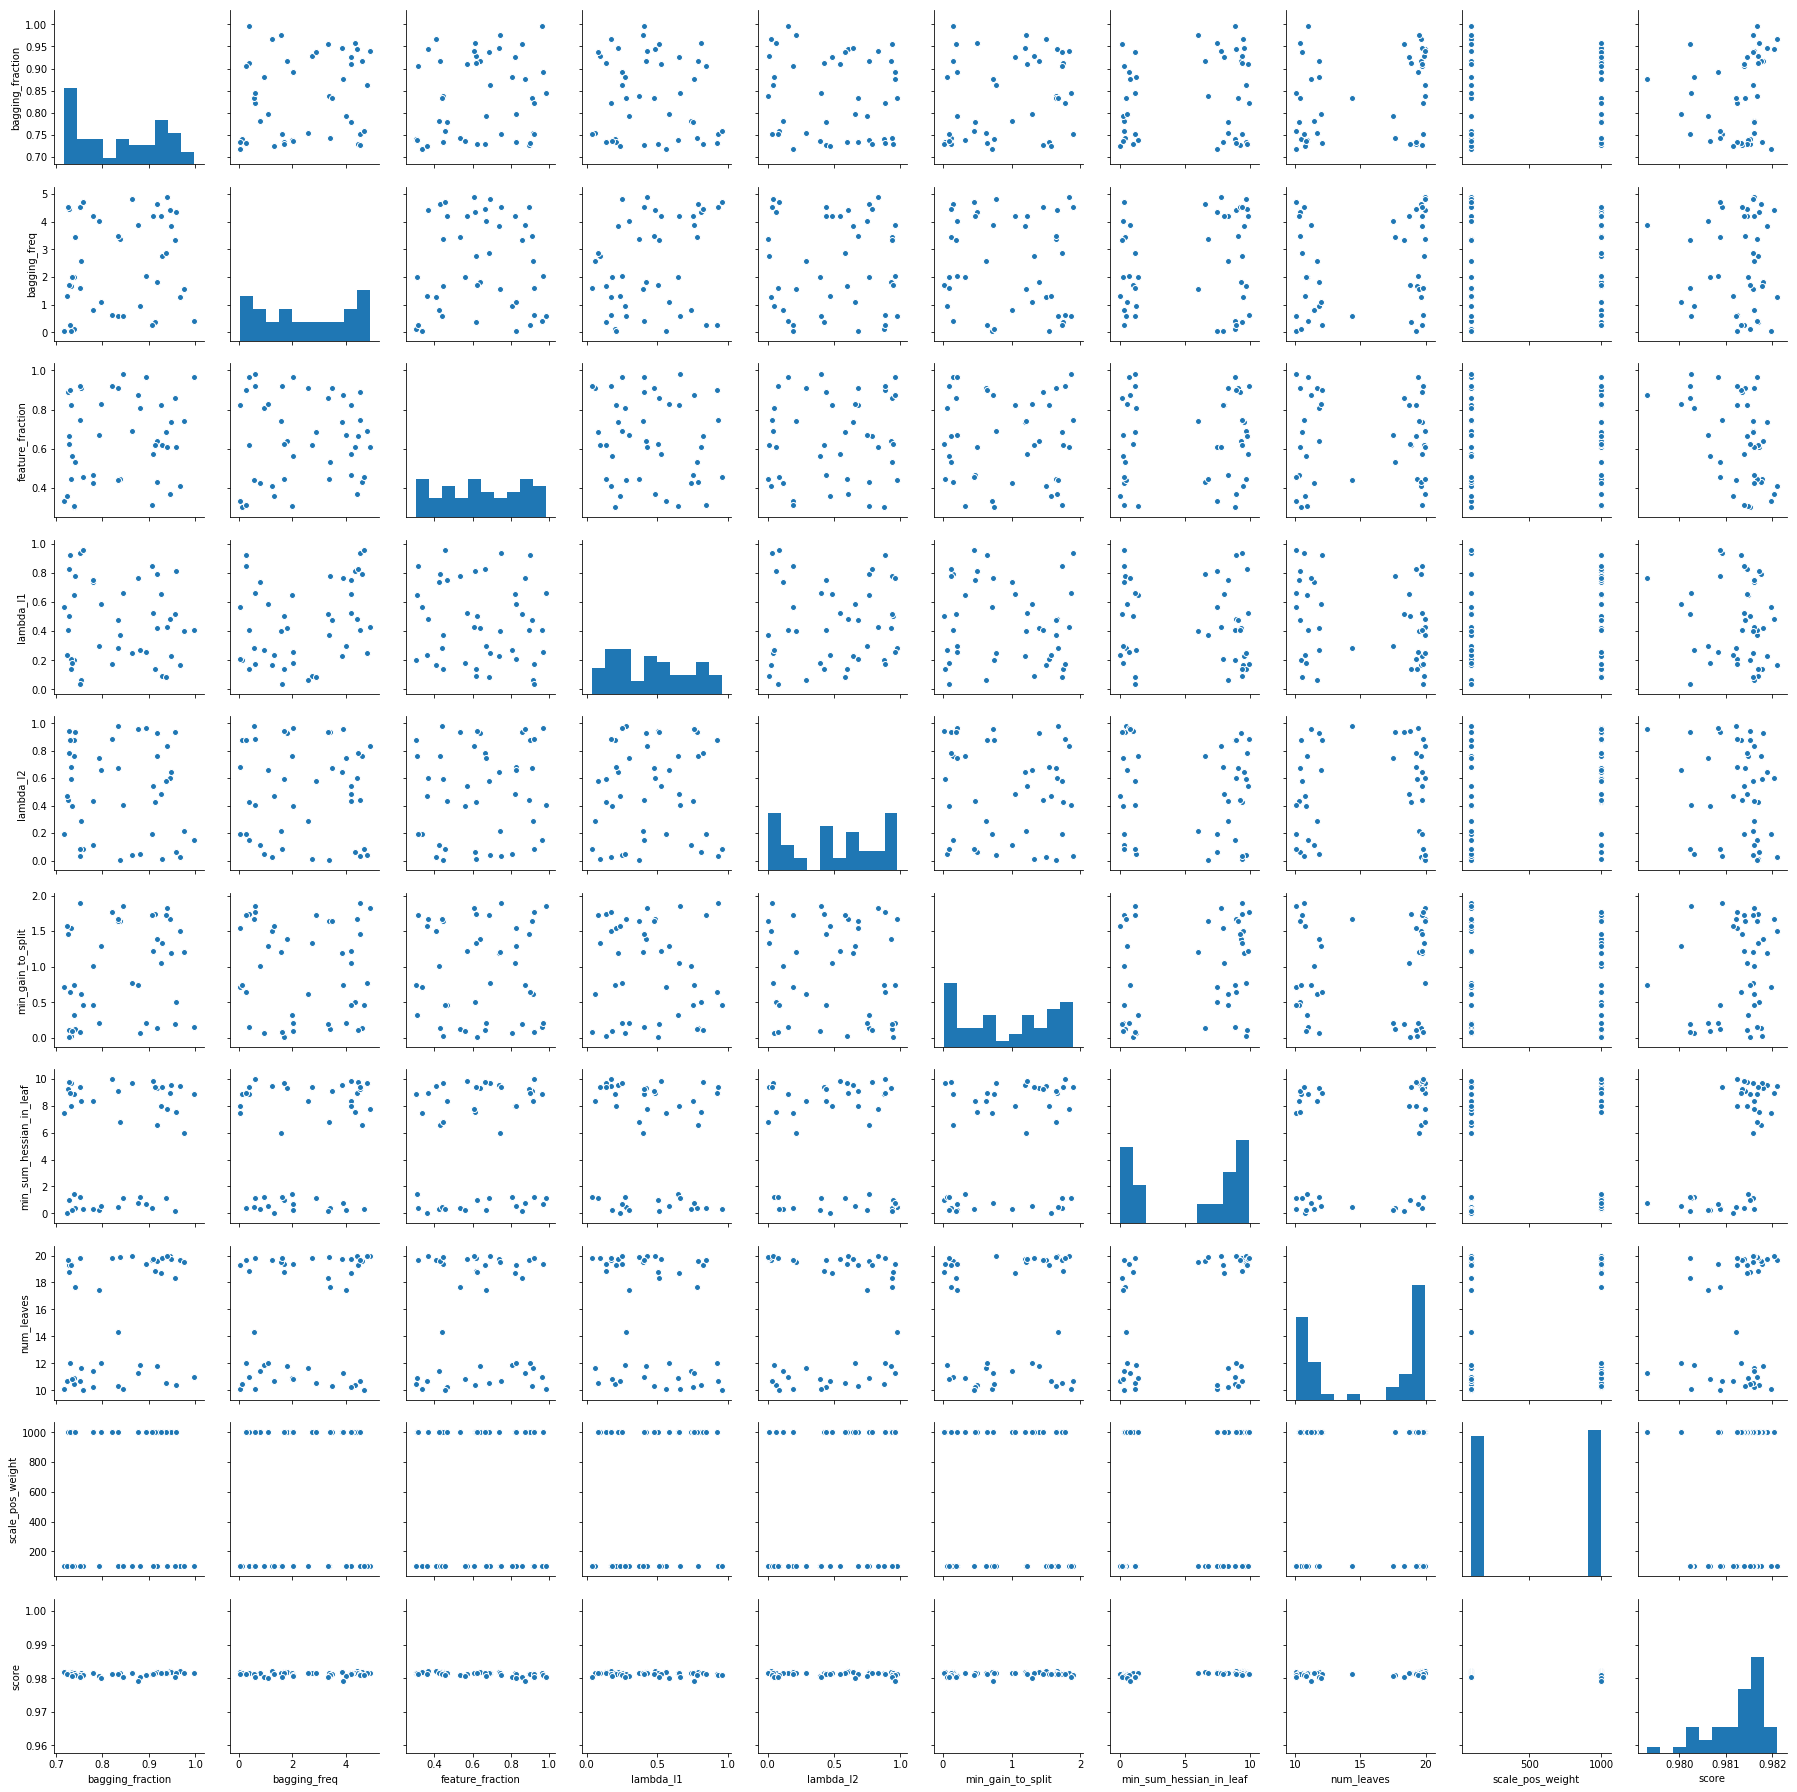

In [30]:
sns.pairplot(lgb_BO_scores)

## Retrain the model

Now we have the all the parameters optimized except num_boost_round. Recall that the optimized num_boost_round depends on learning_rate(eta) which was set to 0.1, a relative larger number. Let's decrease it to 0.01 so we'll likely need a larger num_boost_round but hopefully would yield a better AUC.

In [ ]:
tuned_lgb_params = lgb_BO_scores.iloc[0].to_dict()
best_lgb_params = dict()
best_lgb_params['objective'] = 'binary'
best_lgb_params["metric"] = metric
best_lgb_params['learning_rate'] = 0.1 # Smaller learning rate


best_lgb_params['scale_pos_weight'] = int(tuned_lgb_params['scale_pos_weight'])   
best_lgb_params['num_leaves'] = int(tuned_lgb_params['num_leaves'])    
best_lgb_params['min_sum_hessian_in_leaf'] = int(tuned_lgb_params['min_sum_hessian_in_leaf'])
best_lgb_params['min_gain_to_split'] = tuned_lgb_params['min_gain_to_split']     
best_lgb_params['feature_fraction'] = tuned_lgb_params['feature_fraction']
best_lgb_params['bagging_fraction'] = tuned_lgb_params['bagging_fraction']
best_lgb_params['bagging_freq'] = tuned_lgb_params['bagging_freq']
best_lgb_params['lambda_l1'] = tuned_lgb_params['lambda_l1']
best_lgb_params['lambda_l2'] = tuned_lgb_params['lambda_l2']

print (best_lgb_params)

cv_results = lgb.cv(best_lgb_params, 
                    lgtrain,
                    num_boost_round=1000000,
                    early_stopping_rounds=200, # larger earlyer stopping round is needed 
                    nfold=4,
                    feval=None,
                    stratified=True,
                    shuffle=True,
                    verbose_eval=10)    

cv_results = pd.DataFrame(cv_results)
best_lgb_iteration = len(cv_results)        
if greater_is_better:
    best_lgb_score = cv_results[metric+'-mean'].max()
else:
    best_lgb_score = cv_results[metric+'-mean'].min()

print (', best_score: %f, best_iteration: %d' % (best_lgb_score, best_lgb_iteration))

In [ ]:
model = lgb.train(best_lgb_params,
                  lgb.Dataset(train_x, train_y),
                  num_boost_round=best_lgb_iteration
                  )

preds = model.predict(test_x)

sub_df = pd.DataFrame({'click_id': ids, 'is_attributed': preds})
sub_df.to_csv("../output/lgb_tuned_paras_5M.csv", index=False)

### Question

Recall that in order to speed up the tuning process we actually used only 5M training samples so the submission above may not yield a better result on LB. Can you try training the model with the same amount of training samples and see how it works? You may want to ** leverage the parameters tuned above** without having to rerun the entire process.

## XGBoost (optional)

The following codes are optional as they may take longer time to run. Basically the process is much similar as what's covered above for LightGBM.

### Manual tuning (greedy search)

* Tune one parameter at a time.
* Find the best value for a parameter then move to the next one.
* Repeat the process for all the parameters we want to tune.

In [ ]:
default_xgb_params = {}
default_xgb_params["objective"] = "binary:logistic"
default_xgb_params["eta"] = 0.15
default_xgb_params["seed"] = 1234
default_xgb_params["metric"] = metric

params_xgb_space = {}
params_xgb_space['scale_pos_weight'] = [1, 50, 99, 500, 1000, 5000, 10000]
params_xgb_space['max_depth'] = [4,5,6,7,8,9,10]
params_xgb_space['gamma'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_xgb_space['colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['subsample'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['min_child_weight'] = [0, 1, 3, 10, 30, 100]

greater_is_better = True

In [ ]:
best_xgb_params = default_xgb_params
xgtrain = xgb.DMatrix(train_x, label=train_y)
for p in params_xgb_space:
    print ("Tuning parameter %s in %s" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []    
    for v in params_xgb_space[p]:
        print ('    %s: %s' % (p, v), end="")
        params[p] = v
        cv_results = xgb.cv(params, 
                            xgtrain,
                            nfold=4,   
                            num_boost_round=100000,
                            early_stopping_rounds=30,
                            metrics=metric,
                            stratified=True,
                            shuffle=True,
                            verbose_eval=False)    
        best_iteration = len(cv_results)
        if greater_is_better:
            best_score = cv_results['test-'+metric+'-mean'].max()
        else:
            best_score = cv_results['test-'+metric+'-mean'].min()
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))
    

In [ ]:
def xgb_evaluate(scale_pos_weight,
                 min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.15
    params['scale_pos_weight'] = scale_pos_weight
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['seed'] = 1234    
    

    cv_results = xgb.cv(params, 
                        xgtrain,
                        nfold=4,   
                        num_boost_round=100000,
                        early_stopping_rounds=30,
                        metrics=metric,
                        stratified=True,
                        shuffle=True,
                        verbose_eval=False)    
    best_iteration = len(cv_results)
    if greater_is_better:
        best_score = cv_results['test-'+metric+'-mean'].max()
    else:
        best_score = -cv_results['test-'+metric+'-mean'].min()
    print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))

    return best_score


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'scale_pos_weight': (99, 1000),
                              'max_depth': (5, 11),
                              'min_child_weight': (0, 200),
                              'colsample_bytree': (0.2, 1),
                              'subsample': (0.7, 1),
                              'gamma': (0, 3)
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=20)

In [ ]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head()
lgb_BO_scores.to_csv("../python/tuned_lgb_parameters.csv", index=False)

In [ ]:
best_xgb_params = xgb_BO_scores.iloc[0].to_dict()
best_xgb_params['objective'] = 'reg:linear'
best_xgb_params['eta'] = 0.05  # Smaller

best_xgb_params['scale_pos_weight'] = int(best_xgb_params['scale_pos_weight'])
best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])
best_xgb_params['min_child_weight'] = int(best_xgb_params['min_child_weight'])
best_xgb_params['subsample'] = best_xgb_params['subsample']
best_xgb_params['colsample_bytree'] = best_xgb_params['colsample_bytree']
best_xgb_params['gamma'] = best_xgb_params['gamma']
best_xgb_params['seed'] = 1234

print (best_xgb_params)

cv_results = xgb.cv(params, 
                    xgtrain,
                    nfold=4,   
                    num_boost_round=100000,
                    early_stopping_rounds=30,
                    metrics=metric,
                    stratified=True,
                    shuffle=True,
                    verbose_eval=False)    
best_xgb_iteration = len(cv_results)
if greater_is_better:
    best_xgb_score = cv_results['test-'+metric+'-mean'].max()
else:
    best_xgb_score = -cv_results['test-'+metric+'-mean'].min()
print ('best_score: %f, best_iteration: %d' % (best_xgb_score, best_xgb_iteration))

In [ ]:
model = xgb.train(best_xgb_params, 
                  xgb.DMatrix(train_x, label=train_y), 
                  num_boost_round=best_xgb_iteration)    
preds = model.predict(xgb.DMatrix(test[full_vars].values))

sub_df = pd.DataFrame({'click_id': ids, 'is_attributed': preds})
sub_df.to_csv("../output/xgb_tuned_paras_5M.csv", index=False)

# Conclusions
Paramter tuning plays an important role in practical data science. In this we've learnt:

1. A framework that can be used to guide parameter turnings
2. XGBoost and LightGBM hypter-parameters
3. Manual tuning
4. Automated tuning


# References
* [XGBoost Parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md)
* [XGBoost official tuning guide](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
* [Tianqi Chen’s guide on XGBoost in Chinese](http://www.52cs.org/?p=429)
* [MachineLearningMastery’s XGBoost tutorials](http://machinelearningmastery.com/category/xgboost/)
* [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
* [What to optimize first? Gamma or Depth? What’s up with min_child_weight?](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6)
* [LightGBM Parameters](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst)
* [Parameters Tuning](http://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
* [CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)


# Assignments
* Train LightGBM model with larger amount of training samples with tuned parameters.
* Optimize parameters for XGBoost
* Did you observe any differences before and after parameter tuning? Any differencew between XGBoost and LightGBM? What is your thought on the differences and what caused the differences?